# Diamond Price Predictions

In [1]:
# Miscelaneous
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SKLearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

## Some usefull variables

In [2]:
PATH = '../data/diamonds.csv'

## Getting the data

In [3]:
df = pd.read_csv(PATH)
df.drop(df.columns[0], axis=1, inplace=True)
display(df.head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Carat:** Weight of the diamond.

**Cut Quality:** Quality of the cut (Fair, Good, Very Good, Premium, Ideal).

**Color:** Diamond color from J (worst) to D (best).

**Clarity:** Clarity of the diamond from I1 (worst) (SI2, SI1, VS2, VS1, VVS2, VVS1) to IF (best).

**Depth:** In terms of cut quality, depth is described in percentages. It can be calculated by dividing the diamond's physical depth measurement by its diameter. In our case, depth = z / mean(x, y) = 2 * z / (x + y).
<img src="../data/depth.png" alt="Diamond Depth" width="500"/>

**Table:** Calculated by dividing the diamond's physical table measurement by its diameter.

**X:** Length in mm.

**Y:** Width in mm.

**Z:** Physical depth measurement in mm.
<img src="../data/table.png" alt="Diamond Table" width="500"/>

**Price:** Price in US dollars.

In [4]:
cut_encoder = {'Fair': 0, 'Good': 0.25, 'Very Good': 0.5, 'Premium': 0.75, 'Ideal': 1}
clarity_encoder = {'I1': 0, 'SI2': 0.143, 'SI1': 0.286, 'VS2': 0.429, 'VS1': 0.571, 'VVS2': 0.714, 'VVS1': 0.857, 'IF': 1}
color_encoder = {'J': 0, 'I': 0.167, 'H': 0.333, 'G': 0.5, 'F': 0.667, 'E': 0.833, 'D': 1}
df['cut_encoded'] = df.cut.apply(lambda cut: cut_encoder[cut])
df['clarity_encoded'] = df.clarity.apply(lambda clarity: clarity_encoder[clarity])
df['color_encoded'] = df.color.apply(lambda color: color_encoder[color])

## Analyzing the data

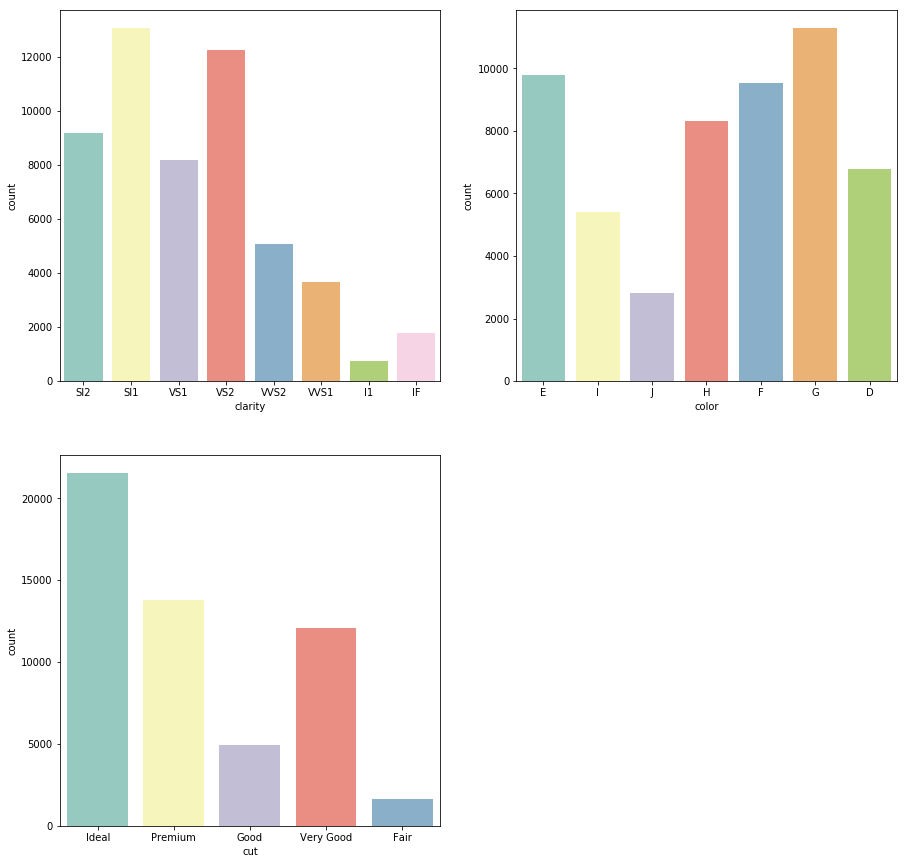

In [5]:
axis = ['clarity', 'color', 'cut']
plt.figure(figsize=(15, 15))
for i in range(3):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=axis[i], data=df, palette="Set3")
plt.show()

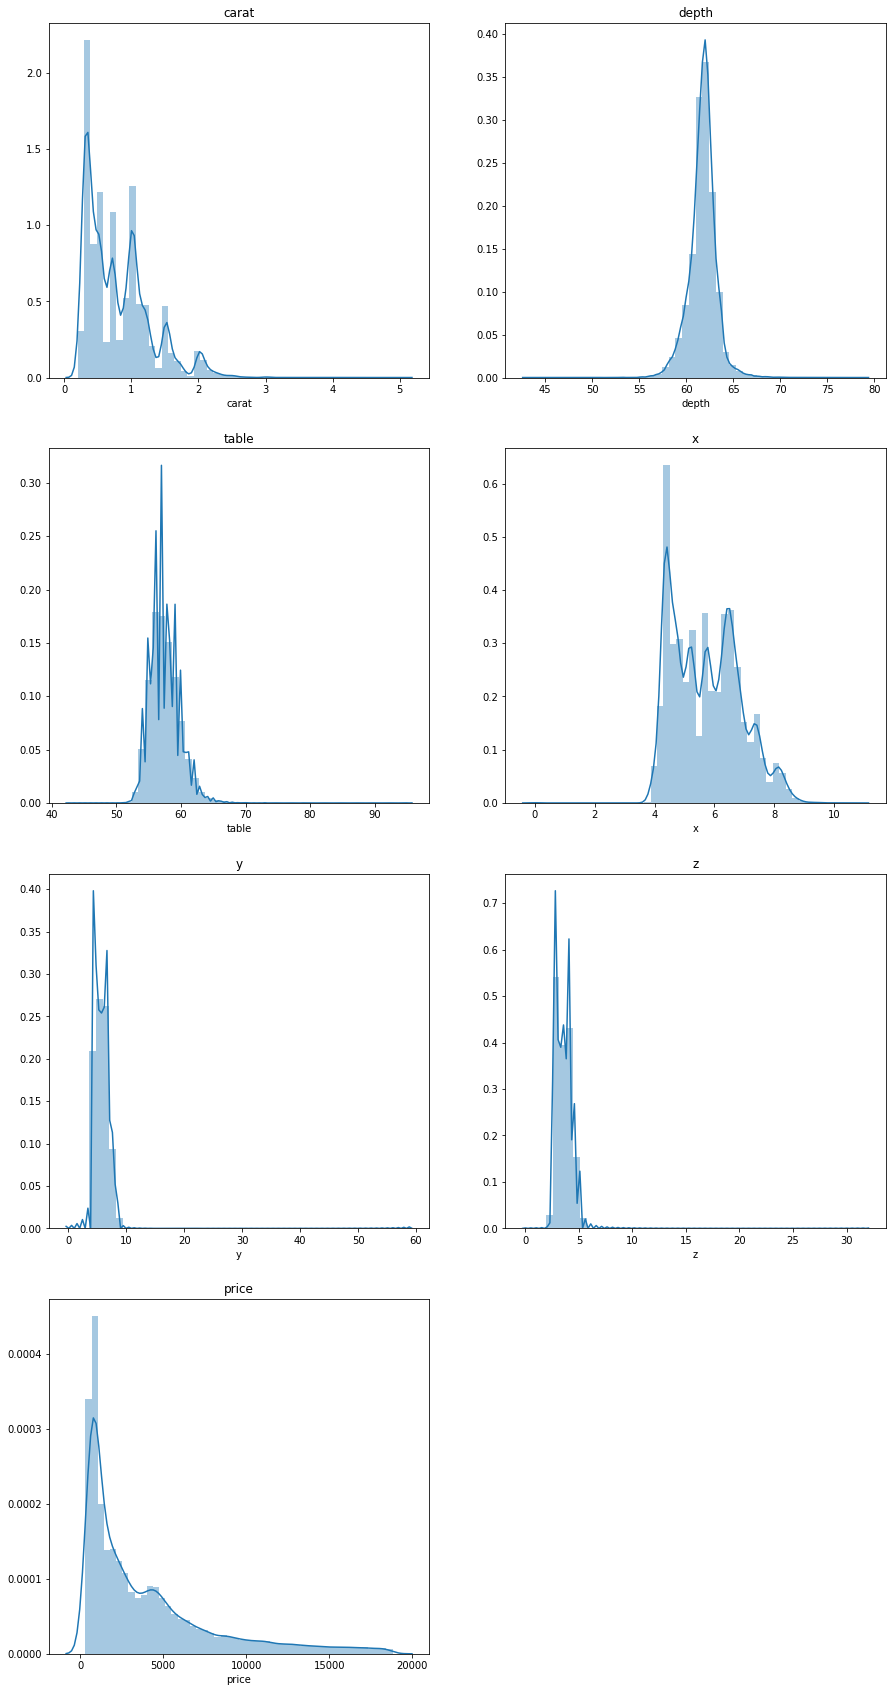

In [6]:
axis = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
plt.figure(figsize=(15, 30))
for i in range(7):
    plt.subplot(4, 2, i + 1)
    sns.distplot(df[axis[i]])
    plt.title(axis[i])
plt.show()

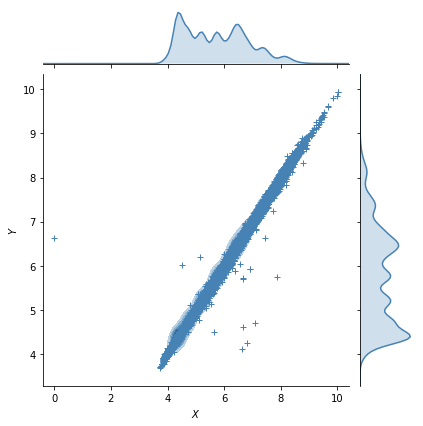

In [7]:
df_filter = df[(df.y > 2) & (df.y < 10)][['x', 'y']]
g = sns.jointplot(x="x", y="y", data=df_filter, kind="kde", color="steelblue")
g.plot_joint(plt.scatter, c="steelblue", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

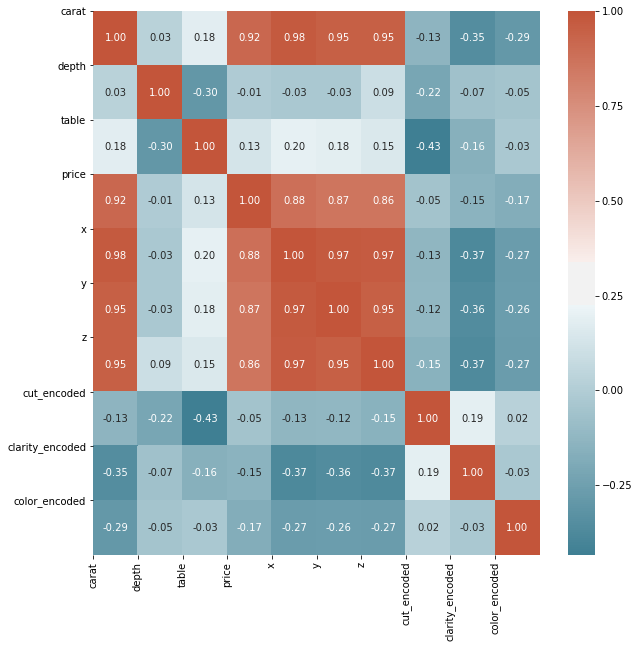

In [8]:
def heatMap(df):
    corr = df.corr()
    plt.subplots(figsize=(10, 10))
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()
heatMap(df)

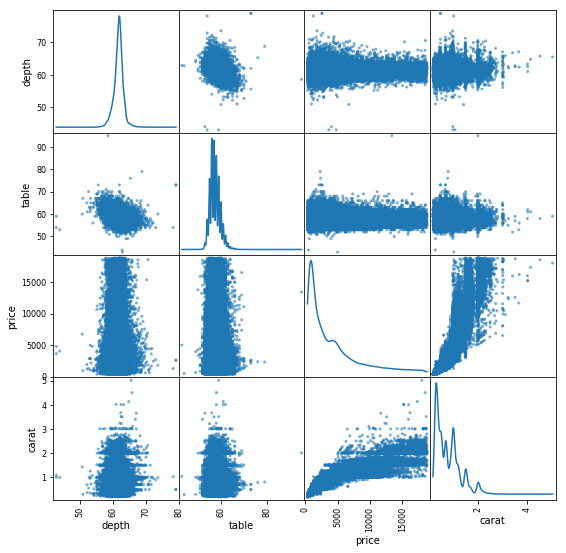

In [9]:
scatter_matrix(df[['depth', 'table', 'price', 'carat']], alpha=0.6, diagonal= 'kde', figsize=(9, 9))
plt.show()

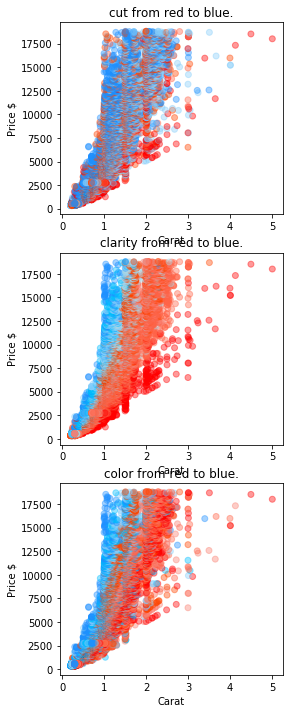

In [10]:
plt.figure(figsize=(4, 12))
colors_map = ['red', 'tomato', 'salmon', 'orangered', 'lightblue', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'blue']
cut_labels = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
clarity_labels = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
color_labels = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
color_names = ['cut', 'clarity', 'color']
labels = [cut_labels, clarity_labels, color_labels]
for i in range(3):
    plt.subplot(3, 1, i + 1)
    colors = df[color_names[i]].apply(lambda x: colors_map[int(labels[i].index(x) / len(labels[i]) * len(colors_map))])
    plt.scatter(df.carat, df.price, alpha=0.4, c=colors)
    plt.xlabel("Carat")
    plt.ylabel("Price $")
    plt.title('{} from red to blue.'.format(color_names[i]))
plt.show()

## Preprocessing the data

**Applying laugarith to the price column for a better distribution. Also removing zeros values in x, y, z**

In [11]:
df.price = np.log(df.price)
df = df[(df['x'] > 0) 
        & (df['y'] > 0) 
        & (df['z'] > 0)
        & (np.abs(df['x'] - df['y']) / df['x'] < 0.2)
        & (df['z'] < 20)]

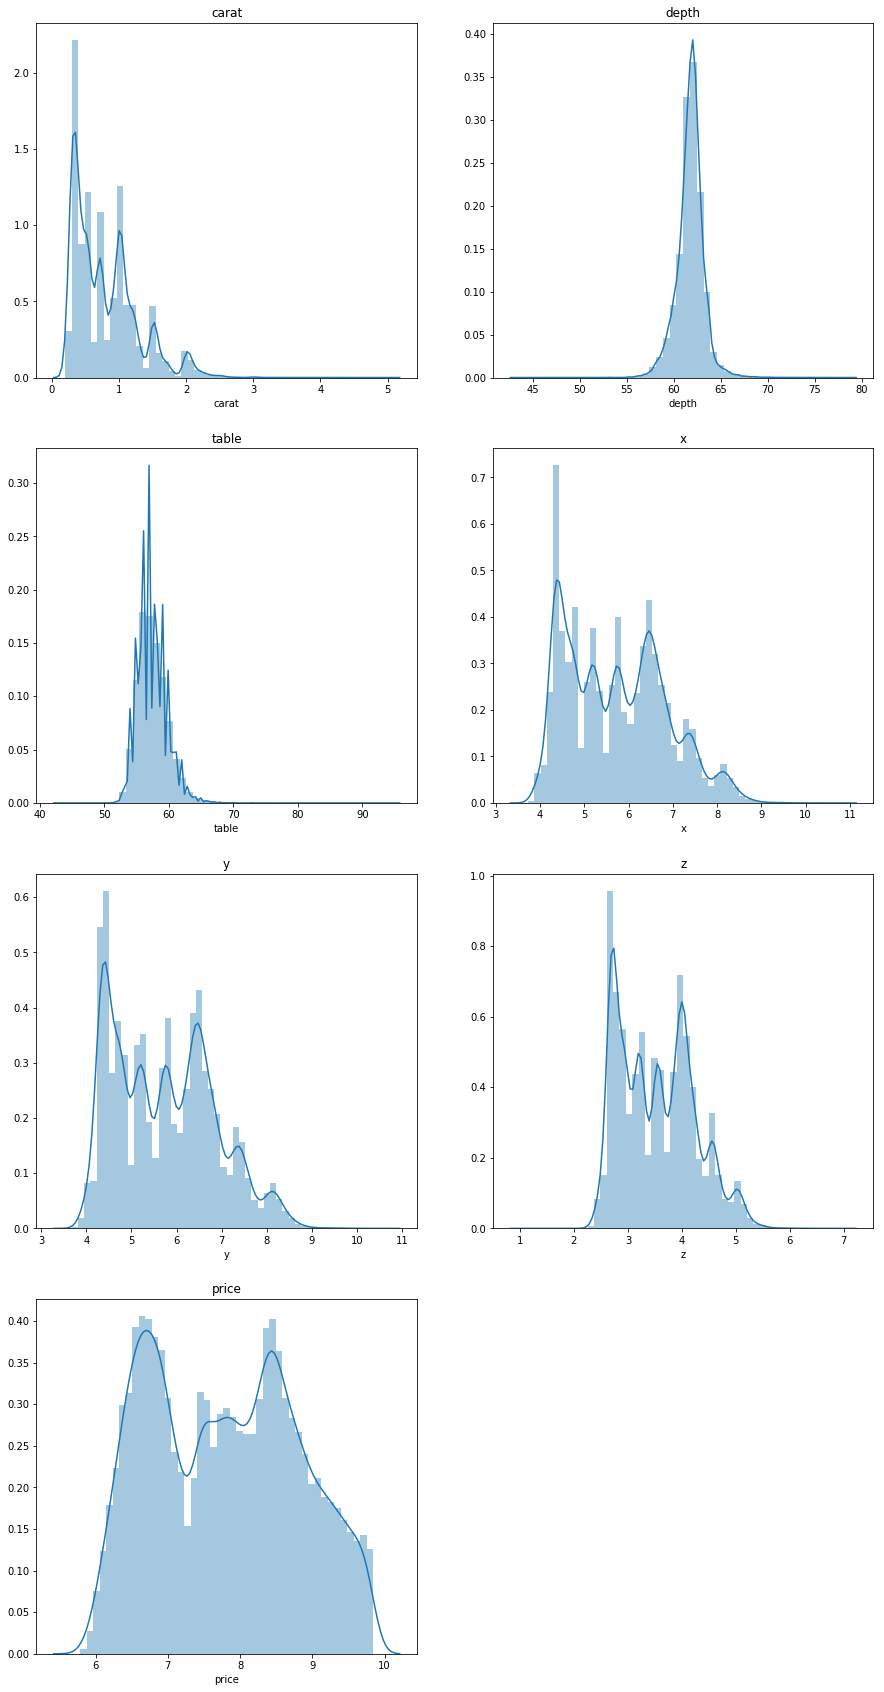

In [12]:
axis = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
plt.figure(figsize=(15, 30))
for i in range(7):
    plt.subplot(4, 2, i + 1)
    sns.distplot(df[axis[i]])
    plt.title(axis[i])
plt.show()

## Training the model

In [48]:
X = np.array(df[['carat', 'depth', 'table', 'cut_encoded', 'clarity_encoded', 'color_encoded']])
Y = np.array(df['price'])
X.shape, Y.shape

((53909, 6), (53909,))

In [49]:
X_center = (X - X.mean(axis=0)) / X.std(axis=0)
X_center.shape,  Y.shape

((53909, 6), (53909,))

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X_center, Y, test_size=0.15)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((45822, 6), (45822,), (8087, 6), (8087,))

In [70]:
LEARNING_RATE = 0.003
EPOCHS = 256
PATIENCE = 128
VERBOSE = True

In [71]:
model = MLPRegressor(hidden_layer_sizes=(64, 64, 64), activation='relu', solver='adam', 
                     batch_size=64, learning_rate='constant', 
                     learning_rate_init=LEARNING_RATE, verbose=True, 
                     max_iter=EPOCHS, n_iter_no_change=PATIENCE)

In [72]:
model.fit(X_train, Y_train)

Iteration 1, loss = 0.56709125
Iteration 2, loss = 0.01189455
Iteration 3, loss = 0.01012435
Iteration 4, loss = 0.00908204
Iteration 5, loss = 0.00927951
Iteration 6, loss = 0.00894892
Iteration 7, loss = 0.00889739
Iteration 8, loss = 0.00862884
Iteration 9, loss = 0.00834359
Iteration 10, loss = 0.00823084
Iteration 11, loss = 0.00837830
Iteration 12, loss = 0.00747370
Iteration 13, loss = 0.00813980
Iteration 14, loss = 0.00736546
Iteration 15, loss = 0.00761895
Iteration 16, loss = 0.00755812
Iteration 17, loss = 0.00758725
Iteration 18, loss = 0.00700407
Iteration 19, loss = 0.00731233
Iteration 20, loss = 0.00716793
Iteration 21, loss = 0.00697039
Iteration 22, loss = 0.00710950
Iteration 23, loss = 0.00684823
Iteration 24, loss = 0.00687198
Iteration 25, loss = 0.00687988
Iteration 26, loss = 0.00676186
Iteration 27, loss = 0.00678570
Iteration 28, loss = 0.00660805
Iteration 29, loss = 0.00679595
Iteration 30, loss = 0.00663622
Iteration 31, loss = 0.00671964
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(64, 64, 64), learning_rate='constant',
       learning_rate_init=0.003, max_iter=256, momentum=0.9,
       n_iter_no_change=128, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [74]:
Y_pred = np.exp(model.predict(X_test))
Y_test_exp = np.exp(Y_test)

In [75]:
print("Mean absolute error is: {:.2f}€ over {} diamond with mean price of {:.2f}€.".format(mean_absolute_error(Y_test_exp, Y_pred), 
                                                                                     len(Y_test_exp), 
                                                                                     Y_test_exp.mean()))
print("Median absolute error is: {:.2f}€ over {} diamond with mean price of {:.2f}€.".format(median_absolute_error(Y_test_exp, Y_pred), 
                                                                                     len(Y_test_exp), 
                                                                                     Y_test_exp.mean()))
print("Mean squared error is: {:.2f}".format(mean_squared_error(Y_test_exp, Y_pred)))
print("R2 score is: {:.5f}".format(r2_score(Y_test_exp, Y_pred)))

Mean absolute error is: 288.52€ over 8087 diamond with mean price of 3855.28€.
Median absolute error is: 119.44€ over 8087 diamond with mean price of 3855.28€.
Mean squared error is: 302762.82
R2 score is: 0.98034


In [76]:
df_comp = pd.DataFrame({'real_price': Y_test_exp, 'pred_price': Y_pred})
display(df_comp.head())

,real_price,pred_price
0,418.0,430.612041
1,3898.0,3947.492309
2,1788.0,1627.938651
3,2523.0,2027.861573
4,583.0,526.662329


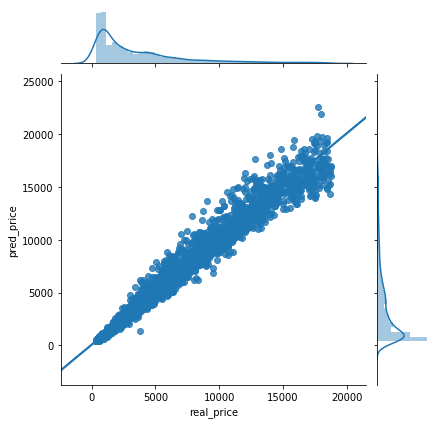

In [77]:
sns.jointplot(x="real_price", y="pred_price", data=df_comp, kind="reg");